📚 Resources

  Essential Paper:
  - https://arxiv.org/abs/2010.11929 - Dosovitskiy et al.

  Reference Implementations:
  - https://github.com/lucidrains/vit-pytorch - Clean, minimal implementation
  - https://github.com/google-research/vision_transformer - Official JAX implementation
  - https://github.com/huggingface/transformers/blob/main/src/transformers/models/vit/modeling_vit.py

  Tutorials & Explainers:
  - https://jalammar.github.io/illustrated-transformer/ - Jay Alammar
  - https://www.youtube.com/watch?v=TrdevFK_am4
  - https://nlp.seas.harvard.edu/2018/04/03/attention.html

  ---
  
Building Blocks

  | Component        |  Task                                              |
  |------------------|---------------------------------------------------|
  | PatchEmbedding   |  Patch Embedding class                                           |
  | Attention        |  Have multiple versions                            |
  | FeedForward      |  Define the MLP block                              |
  | TransformerBlock |  Combine attention + FFN + residuals + LayerNorm   |
  | ViT (full)       |  Add classification head, fix transformer stacking |
  | Training loop    |  Train on CIFAR-10 or MNIST                        |

  ---
  
  

## Step 1 handle Patch Embedding

* this takes an image, and breaks it up into patches. 

* some implementations do it with einops, others with a convolution.  

* if the patch size is 14x14, then we can take a convolution and go from 3 channels to hidden_dim (imagine our input is 224x224).

* the kernel size is the patch size, effectively giving us patches


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F # This gives us the softmax()
import math

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, num_hiddens):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_hiddens = num_hiddens
        self.num_patches = int((self.img_size**2) / (self.patch_size**2))

        self.conv = nn.Conv2d(in_channels=3,
                              out_channels = num_hiddens,
                              kernel_size = patch_size,
                              stride = patch_size)
        
    def forward(self, x):
        x = self.conv(x)
        return x


In [5]:
# !pip install requests

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO

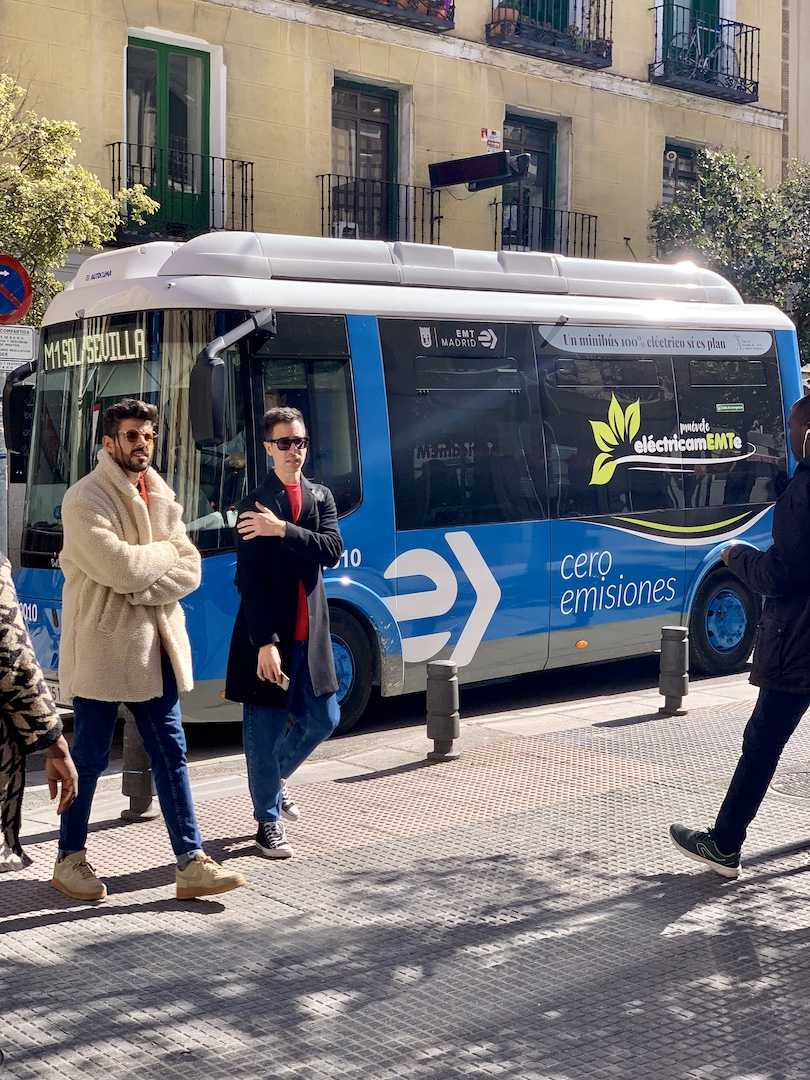

In [8]:
url = "https://ultralytics.com/images/bus.jpg"
img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
img

In [10]:
transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
  ])
img_tensor = transform(img).unsqueeze(0)  # [1, 3, 224, 224]

In [11]:
# Create patch embedding
patch_emb = PatchEmbedding(img_size=224, patch_size=16, num_hiddens=512)
output = patch_emb(img_tensor)  
print(output.size())

torch.Size([1, 512, 14, 14])


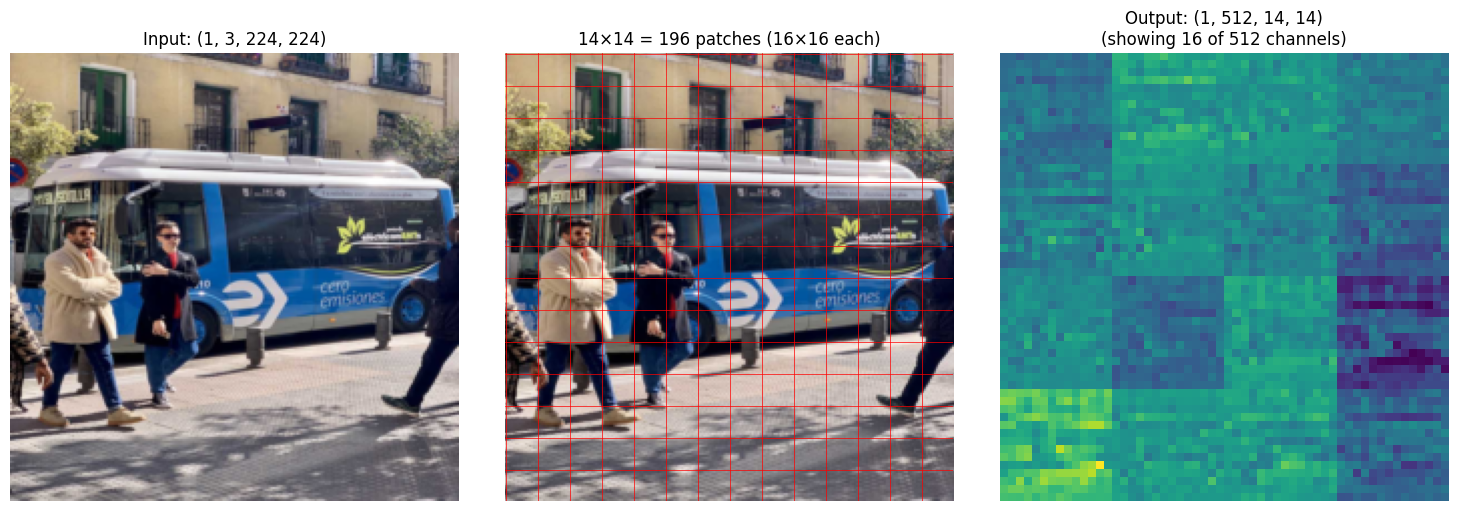

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Original image
axes[0].imshow(img_tensor.squeeze().permute(1, 2, 0))  # [H, W, C]
axes[0].set_title(f'Input: {tuple(img_tensor.shape)}')
axes[0].axis('off')

# 2. Image with patch grid overlay
axes[1].imshow(img_tensor.squeeze().permute(1, 2, 0))
for i in range(0, 224, 16):
    axes[1].axhline(y=i, color='red', linewidth=0.5)
    axes[1].axvline(x=i, color='red', linewidth=0.5)
axes[1].set_title(f'14×14 = 196 patches (16×16 each)')
axes[1].axis('off')

# 3. Output feature map (first 16 channels as a grid)
out_viz = output.squeeze()[:16].detach()  # first 16 of 512 channels
grid = out_viz.reshape(4, 4, 14, 14).permute(0, 2, 1, 3).reshape(56, 56)
axes[2].imshow(grid, cmap='viridis')
axes[2].set_title(f'Output: {tuple(output.shape)}\n(showing 16 of 512 channels)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

* alternative using einops like `lucidrains`:

```
self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )
```

- b = batch_size

- c = channels

- (h p1) = height

- (w p2) is the width

* What are some differences in these two implemetations of PatchEmbeddings? Efficiency?

## Attention

In [13]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.
    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)

In [44]:
sample_img = torch.randn((32, 3, 224, 224))

In [45]:
sample_img.size()

torch.Size([32, 3, 224, 224])

In [2]:
img_size, patch_size, num_hiddens, batch_size = 224, 16, 512, 16
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
print(patch_emb.num_patches)

196


In [5]:
X = torch.zeros(batch_size, 3, img_size, img_size)

In [6]:
patches = patch_emb(X)
print(patches.size())
patches = patches.flatten(2).transpose(1, 2)
print(patches.size())

torch.Size([16, 512, 14, 14])
torch.Size([16, 196, 512])


In [7]:
patches.size() # gives [batch_size, num_patches, num_hiddens] or in nlp [batch_size, seq_len, embedding_dim]

torch.Size([16, 196, 512])

In [ ]:
class Attention(nn.Module):
    def __init__(self, num_hidden, num_heads, dropout=0.1):
        super().__init__()
        self.num_hidden = num_hidden
        self.num_heads = num_heads
        self.dropout = dropout

        self.q = nn.Linear(num_hidden, num_hidden)
        self.k = nn.Linear(num_hidden, num_hidden)
        self.v = nn.Linear(num_hidden, num_hidden)
        self.mha = nn.MultiheadAttention(embed_dim=num_hidden, num_heads=num_heads, dropout=dropout)
        

    def forward(self, x):
        out, attn_weights = self.mha(x, x, x)
        # we get back the outputs, and the attn_weifhts
        return out, attn_weights

In [9]:
att_model = Attention(num_hiddens, 4, 0.2)

In [10]:
X = torch.zeros(batch_size, 3, img_size, img_size)

In [11]:
outs, attn_weights = att_model(patches)

In [26]:
from einops import rearrange, repeat

In [27]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

In [73]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_hiddens, num_heads, num_classes, dropout=0.1):
        super().__init__()
        self.img_size= img_size
        self.patch_size =patch_size
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.num_hiddens = num_hiddens
        self.num_heads = num_heads
        self.num_classes = num_classes
        self.patch_maker = PatchEmbedding(img_size, patch_size, num_hiddens)
        # self.attn_model = Attention(num_hiddens, num_heads, dropout)
        self.layer_norm = nn.LayerNorm(num_hiddens)
        self.pos_embedding = nn.Parameter(torch.randn(1,self.num_patches , num_hiddens))
        self.cls_token = nn.Parameter(torch.randn(1,1 , num_hiddens))
        self.ffn = nn.Sequential(
                                nn.Linear(num_hiddens, num_hiddens*4),
                                nn.GELU(),
                                nn.Dropout(dropout),
                                nn.Linear(num_hiddens*4, num_hiddens),
                                nn.Dropout(dropout)
                            )

    def forward(self, x):
        batch, n_chann, _, _ = x.shape
        patches = self.patch_maker(x)
        patches = patches.flatten(2).transpose(1, 2)
        # need a layerNorm here (?)
        patches = self.layer_norm(patches)
        
        out = self.pos_embedding + patches # these get literally added
        all_cls_tokens = repeat(self.cls_token, '1 n d -> b n d', b=batch)# copy the cls token across the batch
        out = torch.cat((all_cls_tokens, out), dim=1)
        
        out, attn_weights = att_model(out)
        out = self.ffn(out)
        return out

 

In [74]:
num_heads = 8
num_classes = 2
mm = ViT(img_size, patch_size, num_hiddens, num_heads, num_classes)

In [75]:
X.size()

torch.Size([16, 3, 224, 224])

In [76]:
outs = mm(X)

In [77]:
outs.shape

torch.Size([16, 197, 512])

In [78]:
print("mean:", outs.mean().item())
print("std:", outs.std().item())
print("min:", outs.min().item())
print("max:", outs.max().item())

mean: 0.0027136977296322584
std: 0.11333994567394257
min: -0.5969129204750061
max: 0.6218225955963135
